In [1]:
import os
import math

import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from PIL import Image, ImageDraw

from scorefield.models.ddpm.denoising_diffusion import Unet
from scorefield.models.ddpm.denoising_diffusion_1d import Unet1D, GaussianDiffusion1D, Dataset1D, Trainer1D
from scorefield.models.ddpm.gaussian_diffusion import Diffusion
from scorefield.utils.rl_utils import load_config
from scorefield.utils.utils import gen_goals, prepare_input, get_url_image, get_url_pretrained, overlay_image, overlay_goal_agent, overlay_images, overlay_goals_agent, log_num_check
from scorefield.utils.diffusion_utils import bilinear_interpolate

import matplotlib.pyplot as plt


In [2]:
# Args
config_dir = "./scorefield/configs/diffusion.yaml"
args = load_config(config_dir)
device = args['device']

model_path = os.path.join(args['log_path'], args['model_path'])

# map_img = Image.open("map.png")
bg = Image.open('assets/background0.png')
wastes = []
wastes.append(Image.open('assets/waste0.png'))
wastes.append(Image.open('assets/waste4.png'))
wastes.append(Image.open('assets/waste5.png'))

# overlay_image(bg, wastes, torch.tensor([[0,0], [-0.5, 0.5], [-0.5, -0.5]], dtype=torch.float32).cpu())

In [3]:
class Unet2D(Unet):
    def __init__(
        self, 
        dim, 
        out_dim, 
        dim_mults=(1, 2, 4, 8)
    ):
        super().__init__(dim=dim, out_dim=out_dim, dim_mults=dim_mults)

    def forward(self, obs, x_t, t):
        score_map = super().forward(obs, t)
        score = bilinear_interpolate(score_map, x_t)    # output: (B,2)
        return score

img_size = args['image_size']
noise_steps = args['noise_steps']
train_lr = args['train_lr']
beta_start = args['beta_start']
beta_end = args['beta_end']
    
model = Unet2D(
    dim=img_size,
    out_dim = 2,
    dim_mults = (1, 2, 4, 8),
).to(device)

diffusion = Diffusion(
    input_size = (2,), 
    noise_steps= noise_steps,
    device=device,
    beta_start=beta_start,
    beta_end=beta_end,
)

optim = torch.optim.Adam(params=model.parameters(), lr=train_lr)

In [4]:
epochs = 2000 # args['epochs']
batch_size = args['batch_size']
goal_num = args['goal_num']
bounds = args['bounds']

goals = gen_goals(bounds, goal_num)

In [ ]:
assert batch_size % goal_num == 0, 'batch size has to be divided by the goal number'
n = batch_size // goal_num
# expanded_goals = goals.unsqueeze(1).expand(-1, n, -1)

for iters in tqdm(range(goal_num * epochs)):
    goals = gen_goals(bounds, goal_num)
    expanded_goals = goals.unsqueeze(1).expand(-1, n, -1)
    optim.zero_grad()
    
    # x0 = (torch.rand(goal_num, 2, device=device, dtype=torch.float32)*2 -1.) * 0.01 + goals
    random_offsets = (torch.rand(*expanded_goals.shape, device=goals.device, dtype=goals.dtype) * 2 - 1.) * 0.1
    x0 = (expanded_goals + random_offsets).view(-1,2)
    # obs = prepare_input(map_img, img_size, goal_pos=x0, circle_rad=2)
    obs = overlay_image(bg, img_size, wastes, x0)
    t = diffusion.sample_timesteps(batch_size).to(device)
    
    x_noisy, noise = diffusion.forward_diffusion(x0, t)
    noise_pred = model(obs, x_noisy, t)
    loss =  F.l1_loss(noise, noise_pred)
#     loss = F.mse_loss(noise, noise_pred)
    loss.backward()
    optim.step()
    
    if iters % 500 == 0:
        print(f"iter {iters}: {loss.item()}")


  0%|          | 1/6000 [00:01<2:29:06,  1.49s/it]

iter 0: 1.1373515129089355


  0%|          | 21/6000 [00:17<1:17:17,  1.29it/s]

In [9]:
from scorefield.utils.utils import log_num_check, get_url_pretrained

# model_pth = f"./logs/pretrained/diverse_goalpos_{noise_steps}_{beta_start}~{beta_end}.pt"
# model_pth = log_num_check(model_pth)
# torch.save(model.state_dict(), model_pth)

# url = 'https://drive.google.com/uc?export=download&id=1CtqczM5cry7wg4poiCv_UeKfIrLtrx9V'
# get_url_pretrained(url, 'model.pt')
model.load_state_dict(torch.load(f'model.pt'))
# model.load_state_dict(torch.load(f'./logs/pretrained/diverse_goalpos_{noise_steps}_{beta_start}~{beta_end}.pt'))

UnpicklingError: invalid load key, '<'.

499it [00:09, 53.51it/s]
29it [00:16,  1.72it/s]


KeyboardInterrupt: 

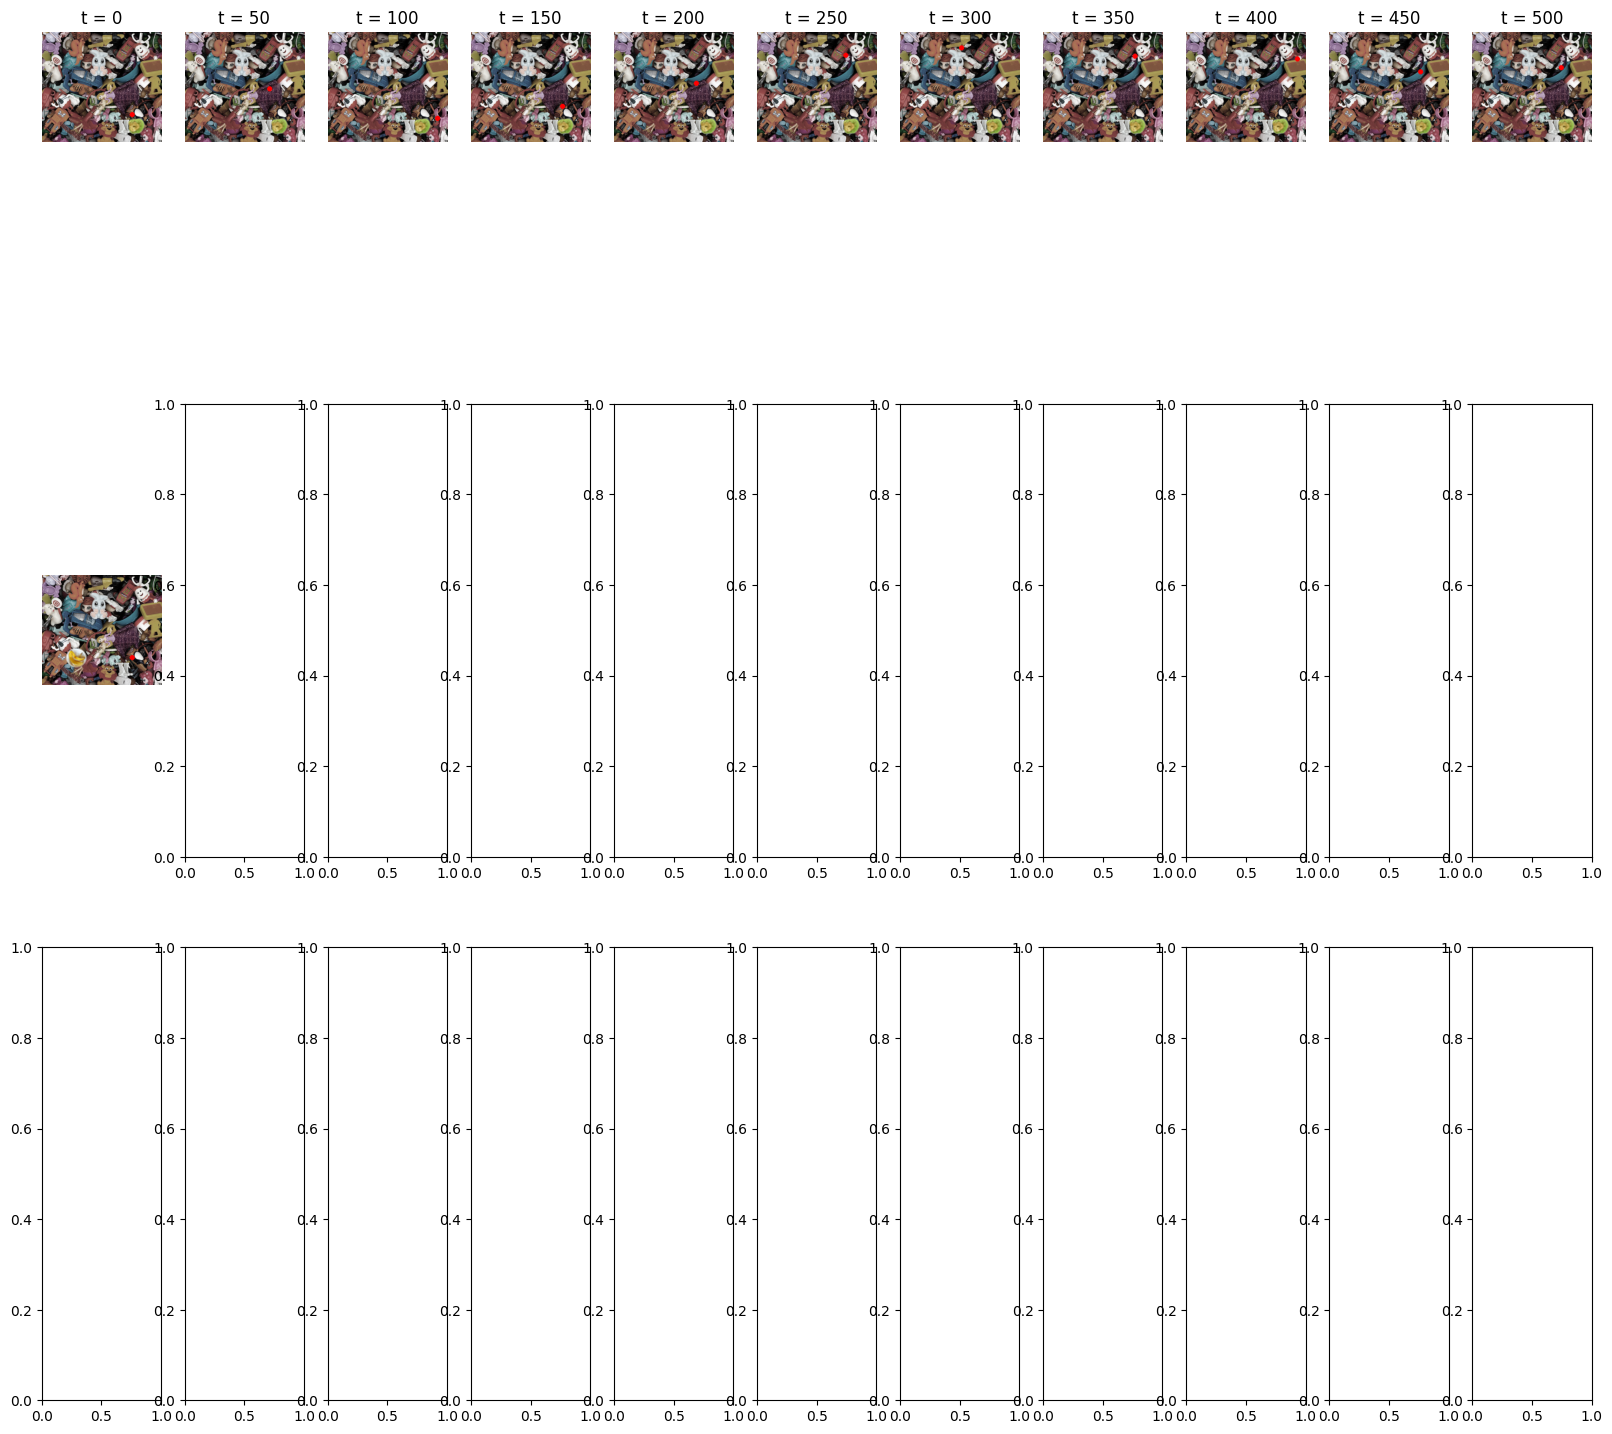

In [7]:
c = 10
fig,axs = plt.subplots(goal_num, c + 1, figsize=(20,20))
# axs = axs.flatten()
T = diffusion.noise_steps
step_size = int(T / c)

# obs_T = prepare_input(map_img, img_size, x_T, circle_rad=2)
new_goals = gen_goals(bounds, goal_num)
obs_T = overlay_image(bg, img_size, wastes, new_goals)

# x_trace = [x]
model.eval()
with torch.no_grad():
    for g in range(goal_num):
        x_T = torch.tensor([[0.5, 0.5]], device=device, dtype=torch.float32)
        x = x_T
        
        for i in tqdm(reversed(range(1, noise_steps)), position=0):
            if (T-1-i) % step_size == 0:
                k = (T-1-i) // step_size
                backg = bg.copy()
                # img_sample = draw_goal_samples(map_img,goals.cpu(), x.cpu())
                img_sample = overlay_goal_agent(backg, wastes[g], new_goals[g].cpu(), x.cpu(), 5)
                axs[g,k].imshow(img_sample)
                axs[0,k].set_title(f't = {T-1-i}')
                axs[g,k].axis('off')

            t = (torch.ones(1) * i).long().to(device)
            while True:
                predicted_noise = model(obs_T[g].unsqueeze(0), x, t)
                alpha = diffusion.alpha[t]
                alpha_hat = diffusion.alpha_hat[t]
                beta = diffusion.beta[t]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) \
                            * predicted_noise) + torch.sqrt(beta) * noise
                if (abs(x[0][0]) <= 1.) & (abs(x[0][1]) <= 1.):
                    break
            # x_trace.append(x)

        backg = bg.copy()
        # img_sample = draw_goal_samples(map_img, goals.cpu(), x.cpu())
        img_sample = overlay_goal_agent(backg, wastes[g], new_goals[g].cpu(),x.cpu(),5)
        axs[g,-1].imshow(img_sample)
        axs[0,-1].set_title(f't = {T}')
        axs[g,-1].axis('off')

499it [00:09, 54.71it/s]


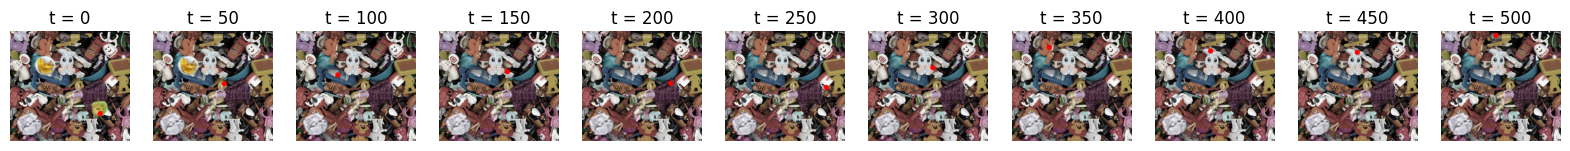

In [11]:
from scorefield.utils.utils import get_distance

c = 10
fig,axs = plt.subplots(1, c + 1, figsize=(20,20))
axs = axs.flatten()
T = diffusion.noise_steps
step_size = int(T / c)

goals = gen_goals(bounds, goal_num)

objs = wastes.copy()
gs = goals.clone()

# obs_T = prepare_input(map_img, img_size, x_T, circle_rad=2)
obs_T = overlay_images(bg, img_size, objs, gs)

# x_trace = [x]
model.eval()
with torch.no_grad():
    x_T = torch.tensor([[0.5, 0.5]], device=device, dtype=torch.float32)
    x = x_T

    for i in tqdm(reversed(range(1, noise_steps)), position=0):
        if (T-1-i) % step_size == 0:
            k = (T-1-i) // step_size
            # img_sample = draw_goal_samples(map_img,goals.cpu(), x.cpu())
            img_sample = overlay_goals_agent(bg, objs, gs.cpu(), x.cpu())
            axs[k].imshow(img_sample)
            axs[k].set_title(f't = {T-1-i}')
            axs[k].axis('off')

        t = (torch.ones(1) * i).long().to(device)
        while True:
            predicted_noise = model(obs_T, x, t)
            alpha = diffusion.alpha[t]
            alpha_hat = diffusion.alpha_hat[t]
            beta = diffusion.beta[t]
            if i > 1:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)
            x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) \
                        * predicted_noise) + torch.sqrt(beta) * noise
            if (abs(x[0][0]) <= 1.) & (abs(x[0][1]) <= 1.):
                break

        exclude_idx = -1
        for i in range(len(gs)):
            if get_distance(x[0], gs[i]) < 0.1 and len(gs) > 1:
                exclude_idx = i
                break
        if exclude_idx > -1:
            objs = objs[:i] + objs[i+1:]
            gs = torch.cat([gs[:i], gs[i+1:]], dim=0)
            obs_T = overlay_images(bg, img_size, objs, gs)
        # x_trace.append(x)

    # img_sample = draw_goal_samples(map_img, goals.cpu(), x.cpu())
    img_sample = overlay_goals_agent(bg, objs, gs.cpu(),x.cpu())
    axs[-1].imshow(img_sample)
    axs[-1].set_title(f't = {T}')
    axs[-1].axis('off')